# **Vaccine Sentiment Classifier using Softmax Regression**
---
## Chalkias Spyridon 

# Table of Contents
---
1. Import the necessary packages
2. Data Preprocessing
3. Experiment with the model
    1. Use Term Frequency - Inverse Document Frequency (TF-IDF) representation with only unigrams
    2. Use Term Frequency - Inverse Document Frequency (TF-IDF) representation with only bigrams
    3. Use Term Frequency - Inverse Document Frequency (TF-IDF) representation with both unigrams and bigrams
    4. Use Count Vectorizer representation with only unigrams
    5. Use Count Vectorizer representation with only bigrams
    6. Use Count Vectorizer representation with both unigrams and bigrams
    7. Use Hashing vectorizer representation with only unigrams
    8. Use Hashing vectorizer representation with only bigrams
    9. Use Hashing vectorizer representation with both unigrams and bigrams
4. Results
5. Test your own set
6. Sources



# Vaccine Sentiment Classifier
---
This project demonstrates the use of  sentiment  analysis  on  a  dataset  consisting  of tweets in order to infer whether a tweet is:
1.  Neutral
2.  Anti-vax
3.  Pro-vax




## 1) Import the necessary packages

In [1]:
%pip install sklearn-genetic-opt
!pip install -q "tqdm>=4.36.1"

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Progress bar
from tqdm.auto import tqdm
tqdm.pandas()

# Dataframe manipulation
import pandas as pd
# Matrix calculations
import numpy as np
from scipy.sparse import csr_matrix
# Visual representations
import matplotlib.pyplot as plt
# Data cleaning
import re
# Data transformation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
# Classification method
from sklearn.linear_model import LogisticRegression
# Pipeline for the classifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
# Performance report
from sklearn.metrics import classification_report, accuracy_score, f1_score
# Data visualization 
from wordcloud import WordCloud 
# Hyperparameter tuning
from sklearn_genetic import GASearchCV
from sklearn_genetic.space import Continuous, Categorical, Integer
from sklearn_genetic.plots import plot_fitness_evolution, plot_search_space
# Learning curve plot
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 139 kB 53.1 MB/s 


# 2) Data Preprocessing

To begin with, each tweet should be channeled into a lemmatization process, in order to retain only the common roots of the words that make it up. Thus, the **spaCy** library was selected for the lemmatization process, while the **NLTK** library was selected as a stopwords container.

In [2]:
# Use an advanced stopword container via NLTK
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
# Import spacy for the lemmatization process
import spacy
nlp = spacy.load('en_core_web_sm')

In order to prepare the dataset, Google Drive has been linked to the current notebook.

**NOTE :** In order to test **your own test set**, proceed to chapter 5 (***Test your own set***). of this notebook.

In [ ]:
at = 'https://github.com/spChalk/Vaccine-Sentiment-Classifier/tree/main/data'

# Dataset filenames
training_set_name = 'vs_train.csv' 
validation_set_name = 'vs_dev.csv' 

# Read the dataset and instantiate the corresponding variables
training_set = pd.read_csv(at + training_set_name, index_col=0)
# Validation set. 
val_set = pd.read_csv(at + validation_set_name, index_col=0)

Have a look at the datasets, its really important to investigate the information provided.

In [ ]:
training_set

,tweet,label
0,Sip N Shop Come thru right now #Marjais #Popul...,0
1,I don't know about you but My family and I wil...,1
2,@MSignorile Immunizations should be mandatory....,2
3,President Obama spoke in favor of vaccination ...,0
4,"""@myfoxla: Arizona monitoring hundreds for mea...",0
...,...,...
15971,@Salon if u believe the anti-vax nutcases caus...,1
15972,How do you feel about parents who don't #vacci...,0
15973,70 Preschoolers Tested for Measles in Simi Val...,0
15974,Finance Minister: Budget offers room to procur...,0


In [ ]:
val_set

,tweet,label
0,@user They had a massive surge in with covid d...,1
1,Required vaccines for school: Parents and guar...,0
2,“@KCStar: Two more Johnson County children hav...,0
3,NV can do better. Which states are the best (a...,2
4,Nothing like killing ourselves w/ our own fear...,2
...,...,...
2277,RT @abc7: Number of measles cases reported in ...,0
2278,"Evidence points to the idea that ""measles affe...",0
2279,"Where's @SavedYouAClick ""@voxdotcom: Why you s...",2
2280,Some of my favorite people have autism. If tha...,2


It is also important to check for imbalanced dataset.

In [ ]:
# Counting Neutral tweets
print(len([i for i in training_set['label'] if i == 0]))
# Counting Anti-Vax tweets
print(len([i for i in training_set['label'] if i == 1]))
# Counting Pro-Vax tweets
print(len([i for i in training_set['label'] if i == 2]))

7458
2073
6445


As we can see, the dataset provided is imbalanced, since the *Neutral* and *Pro-Vax* tweets are far more than the *Anti-Vax* onces. However, this does not stop us from searching for the overall best performing model, since the **weighted f1-score** is able to represent a multiclass model’s performance with confidence.

### Define a Softmax Regressor

In [ ]:
class Softmax_Regressor:
    '''
        Constructor function.
        Receives a training, a testing set and a Vectorizer(opt.).
        Initializes the regressor and processes the dataset by:
            1. Defining a lemmatizer.
            2. Dropping any row that contains null values.
            3. Cleaning the tweets from unnecessary characters.
            4. Displaying an informative wordcloud consisting of keywords.
            5. Lemmatizing and transforming the data.
            6. Removing all stopwords and punctuation marks.
            7. Assigning an efficient softmax classifier. 
    '''
    def __init__(self, train, test, vectorizer=TfidfVectorizer(ngram_range=(1, 2), 
                                        stop_words=nltk.corpus.stopwords.words(),
                                        norm=None, min_df=0.005, max_df=0.85)):

        _train = train.copy(deep=True)
        _test = test.copy(deep=True)

        print('Received input')
        print('Instantiating Lemmatizer... ', end='')
        # Function to return a list of lemmas (without pronouns)
        self.__lemmatok = lambda doc: [token.lemma_ for token in nlp(doc) if token.lemma_ != '-PRON-']
        print('Done')

        print('Dropping null values... ', end='')
        _train.dropna(inplace=True)
        _test.dropna(inplace=True)
        print('Done')

        print('Cleaning the dataset... ', end='')
        self.__clean(_train, 'tweet')
        self.__clean(_test, 'tweet')
        print('Done')

        print('Displaying wordcloud... ', end='')
        self.disp_wordcloud(_train, 'tweet')
        print('Done')
        '''
            Use TfidfVectorizer() or any other provided vectorizer 
            in order to vectorize the input and extract 
            information from unigrams, bigrams or both
        '''
        print('Vectorizing... ', end='')
        self.__x_train, self.__y_train, self.__x_test, self.__y_test = \
                self.__get_representation(vectorizer, _train, _test)
        print('Done')

        # Assign a method that performed well experimentally
        self.method = LogisticRegression(multi_class='multinomial',
                                         C=0.1,
                                         penalty='l2',
                                         solver='newton-cg',
                                         max_iter=1e5,
                                         warm_start=True,
                                         tol=1e-5,
                                         n_jobs=-1)
    '''
        Hyperparameter tuning function (optional).
        The tuning is done by using evolutionary algorithms
        and more specifically, sklearn's GASearchCV function.
    '''
    def hyperparameter_tune(self):

        def assign_GA_Search(dataset):
            
            return GASearchCV(estimator=LogisticRegression(multi_class='multinomial'),
                            scoring='f1_weighted',
                            population_size=10,
                            generations=4,
                            tournament_size=3,
                            elitism=True,
                            crossover_probability=0.8,
                            mutation_probability=0.1,
                            param_grid=dataset,
                            criteria='max',
                            algorithm='eaMuPlusLambda',
                            n_jobs=-1,
                            keep_top_k=1)

        ''' 
            Logistic Regression for multiclass datasets has a lot of parameters
            that must be carefully tuned in order to be fully compatible 
            with each other.
        '''
        grid = {    "C":            Continuous(lower=0.0001, upper=3.0), 
                    "penalty":      Categorical(choices=["l2"]), 
                    "solver":       Categorical(choices=['newton-cg', 'sag', 'lbfgs']),
                    "max_iter":     Integer(lower=100000, upper=100000),
                    "warm_start":   Categorical(choices=[True, False]),
                    "tol":          Continuous(lower=0.00001, upper=0.00001),
                    "n_jobs":       Integer(lower=-1, upper=-1)  }

        # Create a pipeline for scaling and tuning
        print('Running GA Search for hyperparameter tuning... ')
        evolved_estimator = make_pipeline(StandardScaler(with_mean=False), 
                                            assign_GA_Search(grid))
        evolved_estimator.fit(self.__x_train, self.__y_train)
        # Predict
        y_predict = evolved_estimator['gasearchcv'].predict(self.__x_test)
        print('Done')

        # Collect the score
        score = accuracy_score(self.__y_test, y_predict)

        # Assign the result to the class method
        best_estimator = evolved_estimator['gasearchcv']

        # Plot info considering the model's performance during the tuning
        print("Tuned hyperparameters :(best parameters) ", best_estimator.best_params_)
        print("Accuracy :", score)
        self.method = LogisticRegression(**best_estimator.best_params_)
        plot_fitness_evolution(best_estimator)
        plt.show()
        print(' ')
        plot_search_space(best_estimator)
        plt.show()

    # Display a wordcloud consisting of all the keywords
    def disp_wordcloud(self, df, label):
        stop_words = nltk.corpus.stopwords.words()
        wc = WordCloud(max_words=250, stopwords=stop_words).generate(' '.join(df[label].tolist()))
        plt.figure(figsize=(10,10))
        plt.imshow(wc)
        plt.axis('off')
        plt.show()
        print()

    def __clean(self, data, label):    
        data[label] = data[label].str.replace('http\S+|www.\S+', '', case=False)    # Remove URLs from dataset
        data[label] = data[label].str.replace(r'\<.*\>', '')                        # Remove noise contained in '< >' parenthesis
        data[label] = data[label].str.replace('RT ', '', case=False)                # Remove the phrase 'RT' from all strings
        data[label] = data[label].str.replace('@[^\s]+', '', case=False)            # Remove '@' and the following twitter name from strings
        data[label] = data[label].str.replace('[^\w\s]', ' ')                       # Remove any punctuation
        data[label] = data[label].str.replace('\r\n', ' ')                          # Remove '\r\n' which is present in some strings
        data[label] = data[label].str.replace('\d+', '').str.lower().str.strip()    # Remove numbers, capitalisation and white space
        data[label] = data[label].progress_map(lambda x: " ".join(self.__lemmatok(x))) # Lemmatize the data

    # Get a representation based on a given vectorizer
    def __get_representation(self, vectorizer, train, test):
        # Collect labels
        y_train = train['label']
        y_test = test['label']
        # Vectorize training and testing set.
        # We use fit_transform() on the training set, in order to learn 
        # the parameters of scaling on the training set and in the same
        # time we scale the train data. We only use transform() on 
        # the testing set, because we use the scaling paramaters learned 
        # on the train data to scale the test data.
        x_train = vectorizer.fit_transform(train['tweet'])
        x_test = vectorizer.transform(test['tweet'])
        return x_train, y_train, x_test, y_test

    def fit(self):

        # Make a pipeline consisting of a scaler and the classification method
        pipe = make_pipeline(StandardScaler(with_mean=False), self.method)
        # Apply scaling on training data
        pipe.fit(self.__x_train, self.__y_train)  
        # Apply scaling on testing data, without leaking training data.
        y_pred = pipe.predict(self.__x_test)
        # Print the report
        print(classification_report(self.__y_test, y_pred))
        accuracy = accuracy_score(self.__y_test, y_pred);
        print('Accuracy is {:.2f} %'.format(accuracy*100))

    def plot_learning_curve(self):

        print('Plotting learning curve...')

        def _plot_learning_curve(
            estimator,
            title,
            X,
            y,
            axes=None,
            ylim=None,
            cv=None,
            n_jobs=None,
            train_sizes=np.linspace(0.1, 1.0, 5),
        ):
            """
            Generate 3 plots: the test and training learning curve, the training
            samples vs fit times curve, the fit times vs score curve.

            Parameters
            ----------
            estimator : estimator instance
                An estimator instance implementing `fit` and `predict` methods which
                will be cloned for each validation.

            title : str
                Title for the chart.

            X : array-like of shape (n_samples, n_features)
                Training vector, where ``n_samples`` is the number of samples and
                ``n_features`` is the number of features.

            y : array-like of shape (n_samples) or (n_samples, n_features)
                Target relative to ``X`` for classification or regression;
                None for unsupervised learning.

            axes : array-like of shape (3,), default=None
                Axes to use for plotting the curves.

            ylim : tuple of shape (2,), default=None
                Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

            cv : int, cross-validation generator or an iterable, default=None
                Determines the cross-validation splitting strategy.
                Possible inputs for cv are:

                - None, to use the default 5-fold cross-validation,
                - integer, to specify the number of folds.
                - :term:`CV splitter`,
                - An iterable yielding (train, test) splits as arrays of indices.

                For integer/None inputs, if ``y`` is binary or multiclass,
                :class:`StratifiedKFold` used. If the estimator is not a classifier
                or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

                Refer :ref:`User Guide <cross_validation>` for the various
                cross-validators that can be used here.

            n_jobs : int or None, default=None
                Number of jobs to run in parallel.
                ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
                ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
                for more details.

            train_sizes : array-like of shape (n_ticks,)
                Relative or absolute numbers of training examples that will be used to
                generate the learning curve. If the ``dtype`` is float, it is regarded
                as a fraction of the maximum size of the training set (that is
                determined by the selected validation method), i.e. it has to be within
                (0, 1]. Otherwise it is interpreted as absolute sizes of the training
                sets. Note that for classification the number of samples usually have
                to be big enough to contain at least one sample from each class.
                (default: np.linspace(0.1, 1.0, 5))
            """
            if axes is None:
                _, axes = plt.subplots(1, 3, figsize=(20, 5))

            axes[0].set_title(title)
            if ylim is not None:
                axes[0].set_ylim(*ylim)
            axes[0].set_xlabel("Training examples")
            axes[0].set_ylabel("Score")

            train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
                estimator,
                X,
                y,
                cv=cv,
                n_jobs=n_jobs,
                train_sizes=train_sizes,
                return_times=True,
                scoring='f1_weighted'
            )
            train_scores_mean = np.mean(train_scores, axis=1)
            train_scores_std = np.std(train_scores, axis=1)
            test_scores_mean = np.mean(test_scores, axis=1)
            test_scores_std = np.std(test_scores, axis=1)
            fit_times_mean = np.mean(fit_times, axis=1)
            fit_times_std = np.std(fit_times, axis=1)

            # Plot learning curve
            axes[0].grid()
            axes[0].fill_between(
                train_sizes,
                train_scores_mean - train_scores_std,
                train_scores_mean + train_scores_std,
                alpha=0.1,
                color="r",
            )
            axes[0].fill_between(
                train_sizes,
                test_scores_mean - test_scores_std,
                test_scores_mean + test_scores_std,
                alpha=0.1,
                color="g",
            )
            axes[0].plot(
                train_sizes, train_scores_mean, "o-", color="r", label="Training score"
            )
            axes[0].plot(
                train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
            )
            axes[0].legend(loc="best")

            # Plot n_samples vs fit_times
            axes[1].grid()
            axes[1].plot(train_sizes, fit_times_mean, "o-")
            axes[1].fill_between(
                train_sizes,
                fit_times_mean - fit_times_std,
                fit_times_mean + fit_times_std,
                alpha=0.1,
            )
            axes[1].set_xlabel("Training examples")
            axes[1].set_ylabel("fit_times")
            axes[1].set_title("Scalability of the model")

            # Plot fit_time vs score
            axes[2].grid()
            axes[2].plot(fit_times_mean, test_scores_mean, "o-")
            axes[2].fill_between(
                fit_times_mean,
                test_scores_mean - test_scores_std,
                test_scores_mean + test_scores_std,
                alpha=0.1,
            )
            axes[2].set_xlabel("fit_times")
            axes[2].set_ylabel("Score")
            axes[2].set_title("Performance of the model")

            return plt

        def concatenate_csr_matrices_by_columns(matrix1, matrix2):
            new_data = np.concatenate((matrix1.data, matrix2.data))
            new_indices = np.concatenate((matrix1.indices, matrix2.indices))
            new_ind_ptr = matrix2.indptr + len(matrix1.data)
            new_ind_ptr = new_ind_ptr[1:]
            new_ind_ptr = np.concatenate((matrix1.indptr, new_ind_ptr))

            return csr_matrix((new_data, new_indices, new_ind_ptr))

        fig, axes = plt.subplots(3, 1, figsize=(10, 15))
        
        title = "Learning Curves (Softmax Regression)"

        # Concatenate all training and testing items
        X = concatenate_csr_matrices_by_columns(self.__x_train, self.__x_test) 
        y = pd.concat([self.__y_train, self.__y_test], ignore_index=True) 

        x_train_len = self.__x_train.shape[0]
        x_test_len = self.__x_test.shape[0]

        train_indices = list(range(0, x_train_len)) 
        test_indices = list(range(x_train_len, x_train_len + x_test_len))

        # Create 1 fold custom cross validator
        cv = [(train_indices, test_indices)]

        estimator = self.method
        _plot_learning_curve(
            estimator, title, X, y, axes=axes, cv=cv, n_jobs=-1
        )

        plt.show()

# 3) Experiment with the model

### 3.1) Use Term Frequency - Inverse Document Frequency (TF-IDF) representation with only unigrams

Received input
Instantiating Lemmatizer... Done
Dropping null values... Done
Cleaning the dataset... 

  0%|          | 0/15976 [00:00<?, ?it/s]

  0%|          | 0/2282 [00:00<?, ?it/s]

Done
Displaying wordcloud... 

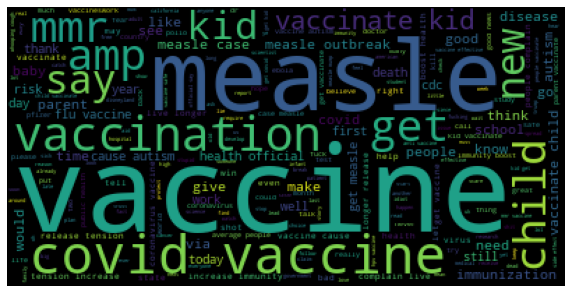


Done
Vectorizing... Done


In [ ]:
tfidf_uni = Softmax_Regressor(training_set, val_set, 
                                    TfidfVectorizer(ngram_range=(1, 1), 
                                        stop_words=nltk.corpus.stopwords.words(),
                                        norm=None, min_df=0.005, max_df=0.85))

Running GA Search for hyperparameter tuning... 
gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	10    	0.670098	4.62414e-05	0.670224   	0.670028   
1  	17    	0.670143	6.16197e-05	0.670224   	0.670087   
2  	17    	0.670195	5.13006e-05	0.670234   	0.670094   
3  	19    	0.670226	9.522e-06  	0.670234   	0.6702     
4  	18    	0.67023 	3.4175e-06 	0.670234   	0.670224   
Done
Tuned hyperparameters :(best parameters)  {'C': 1.6257705403278195, 'penalty': 'l2', 'solver': 'sag', 'max_iter': 100000, 'warm_start': False, 'tol': 1e-05, 'n_jobs': -1}
Accuracy : 0.6858019281332165


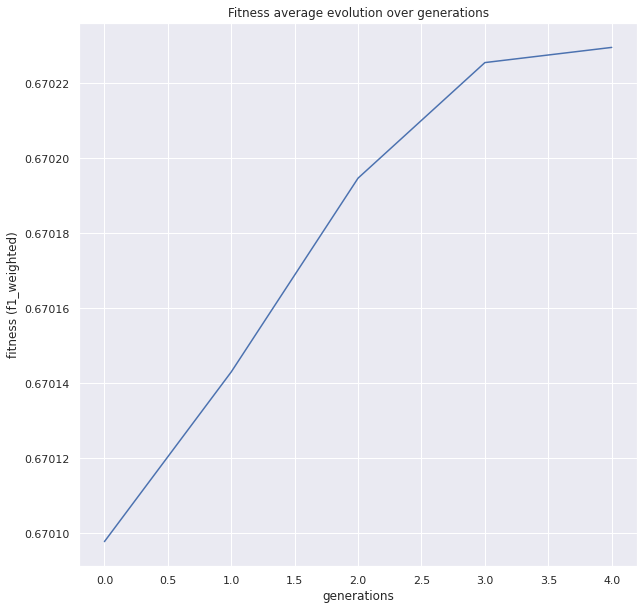

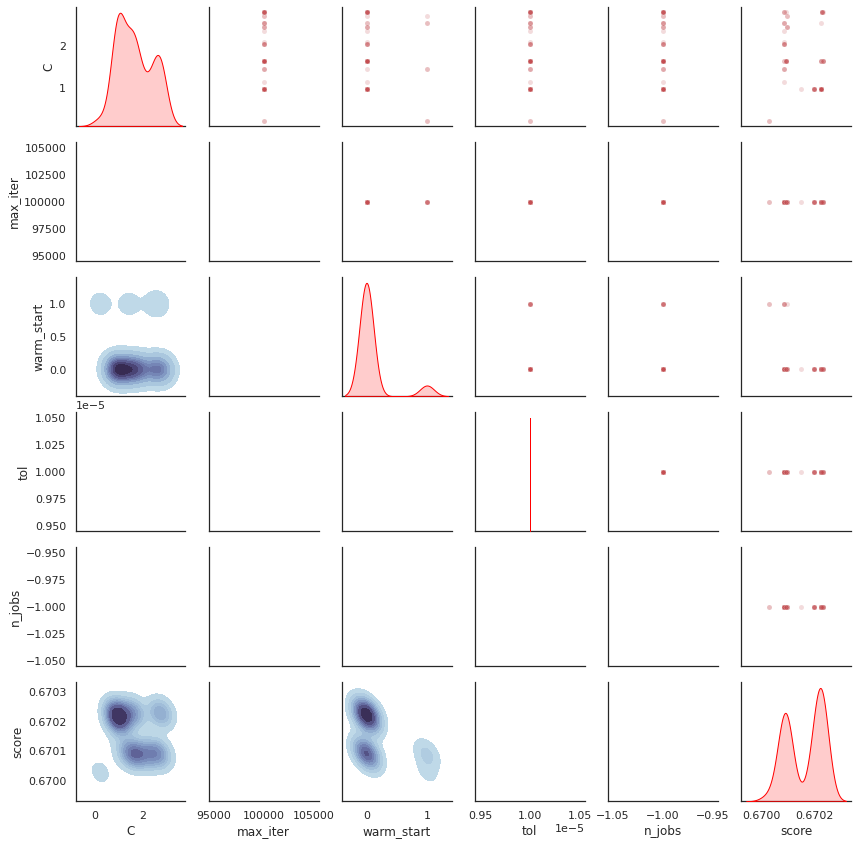

In [ ]:
tfidf_uni.hyperparameter_tune()

In [ ]:
tfidf_uni.fit()

              precision    recall  f1-score   support

           0       0.75      0.77      0.76      1065
           1       0.56      0.30      0.39       296
           2       0.65      0.72      0.69       921

    accuracy                           0.69      2282
   macro avg       0.65      0.60      0.61      2282
weighted avg       0.68      0.69      0.68      2282

Accuracy is 69.19 %


Plotting learning curve...


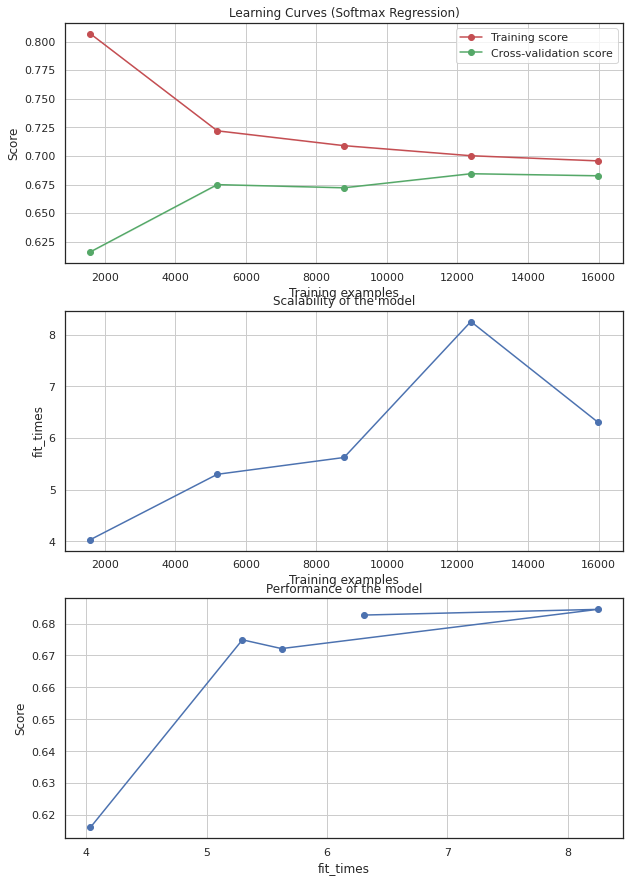

In [ ]:
tfidf_uni.plot_learning_curve()

### 3.2) Use Term Frequency - Inverse Document Frequency (TF-IDF) representation with only bigrams

Received input
Instantiating Lemmatizer... Done
Dropping null values... Done
Cleaning the dataset... 

  0%|          | 0/15976 [00:00<?, ?it/s]

  0%|          | 0/2282 [00:00<?, ?it/s]

Done
Displaying wordcloud... 

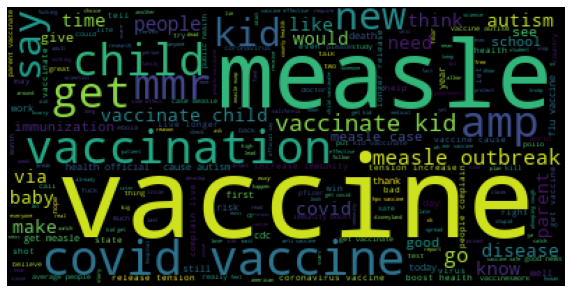


Done
Vectorizing... Done


In [ ]:
tfidf_bi = Softmax_Regressor(training_set, val_set, 
                                    TfidfVectorizer(ngram_range=(2, 2), 
                                        stop_words=nltk.corpus.stopwords.words(),
                                        norm=None, min_df=0.003, max_df=0.9))

Running GA Search for hyperparameter tuning... 
gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	10    	0.549672	3.1917e-05 	0.549767   	0.549658   
1  	13    	0.549687	4.03664e-05	0.549767   	0.549658   
2  	17    	0.549707	4.91764e-05	0.549767   	0.549664   
3  	19    	0.549747	3.95033e-05	0.549767   	0.549664   
4  	18    	0.549748	3.76224e-05	0.549767   	0.549673   
Done
Tuned hyperparameters :(best parameters)  {'C': 0.08228740565921797, 'penalty': 'l2', 'solver': 'lbfgs', 'max_iter': 100000, 'warm_start': False, 'tol': 1e-05, 'n_jobs': -1}
Accuracy : 0.5924627519719544


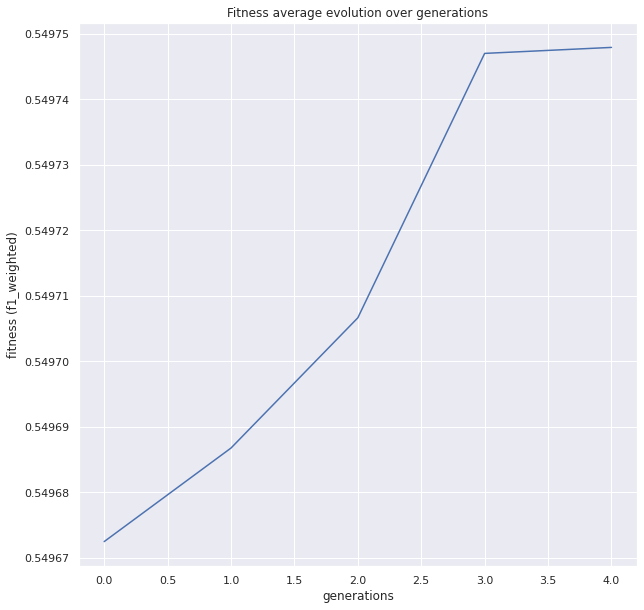

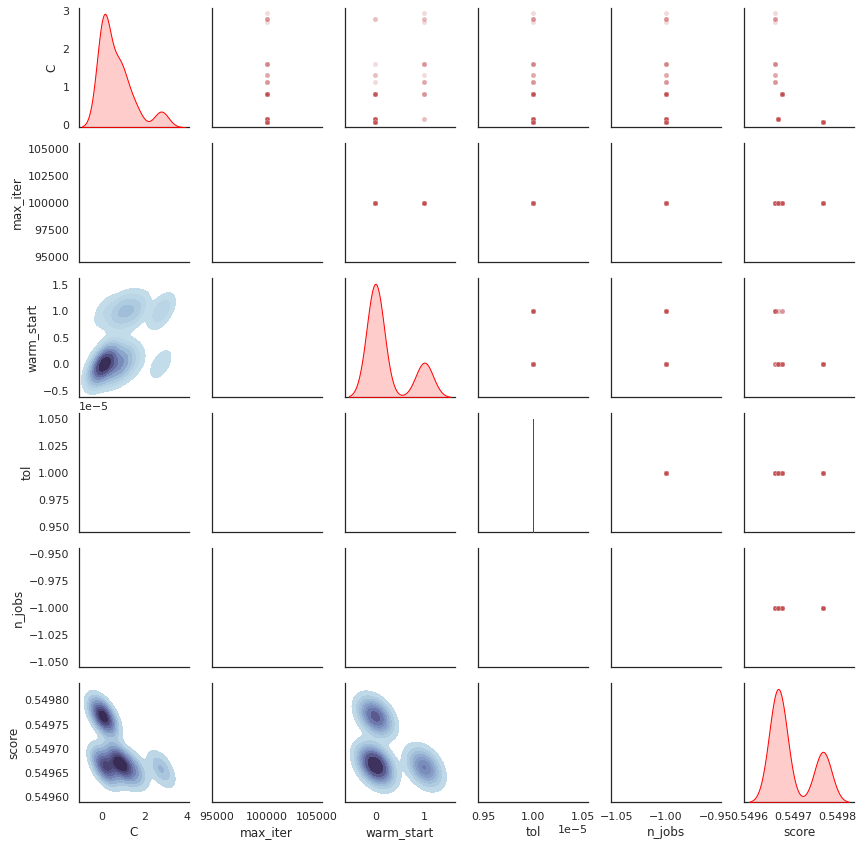

In [ ]:
tfidf_bi.hyperparameter_tune()

In [ ]:
tfidf_bi.fit()

              precision    recall  f1-score   support

           0       0.58      0.89      0.70      1065
           1       0.47      0.05      0.09       296
           2       0.67      0.44      0.53       921

    accuracy                           0.60      2282
   macro avg       0.57      0.46      0.44      2282
weighted avg       0.60      0.60      0.55      2282

Accuracy is 60.04 %


Plotting learning curve...


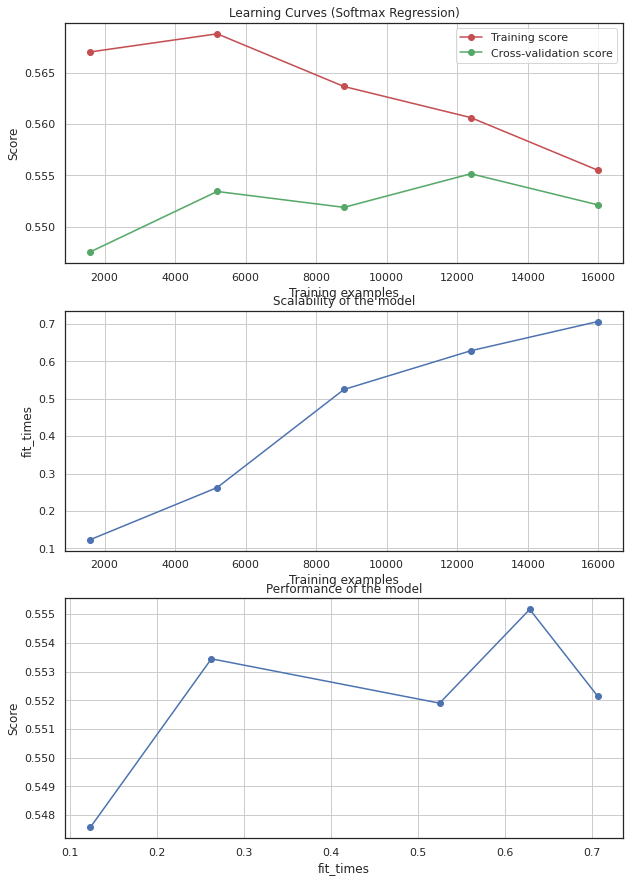

In [ ]:
tfidf_bi.plot_learning_curve()

### 3.3) Use Term Frequency - Inverse Document Frequency (TF-IDF) representation with both unigrams and bigrams

Received input
Instantiating Lemmatizer... Done
Dropping null values... Done
Cleaning the dataset... 

  0%|          | 0/15976 [00:00<?, ?it/s]

  0%|          | 0/2282 [00:00<?, ?it/s]

Done
Displaying wordcloud... 

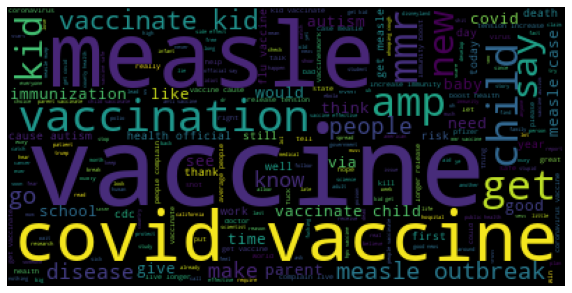


Done
Vectorizing... Done


In [ ]:
tfidf_unibi = Softmax_Regressor(training_set, val_set, 
                                    TfidfVectorizer(ngram_range=(1, 2), 
                                        stop_words=nltk.corpus.stopwords.words(),
                                        norm=None, min_df=0.004, max_df=0.85))

Running GA Search for hyperparameter tuning... 
gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	10    	0.683486	0.000106796	0.683675   	0.68327    
1  	20    	0.68355 	4.82679e-05	0.683675   	0.683466   
2  	18    	0.683561	3.80086e-05	0.683675   	0.683548   
3  	18    	0.683599	8.37422e-05	0.6838     	0.683548   
4  	20    	0.683712	9.7825e-05 	0.6838     	0.683548   
Done
Tuned hyperparameters :(best parameters)  {'C': 0.14577444045221755, 'penalty': 'l2', 'solver': 'newton-cg', 'max_iter': 100000, 'warm_start': True, 'tol': 1e-05, 'n_jobs': -1}
Accuracy : 0.6958808063102542


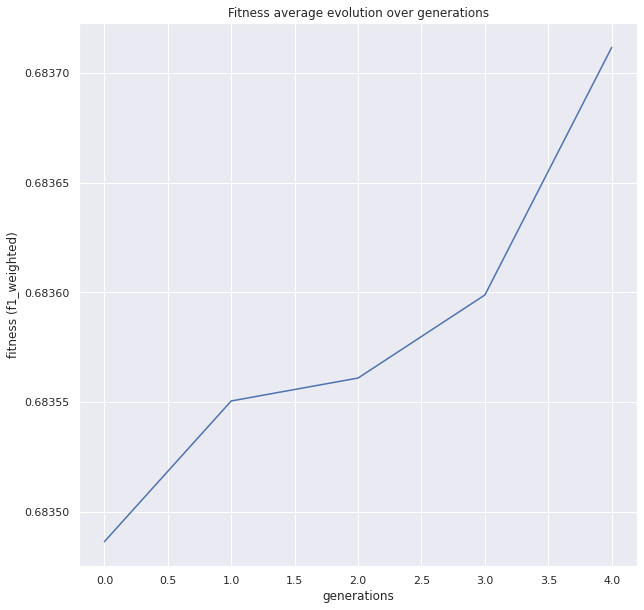

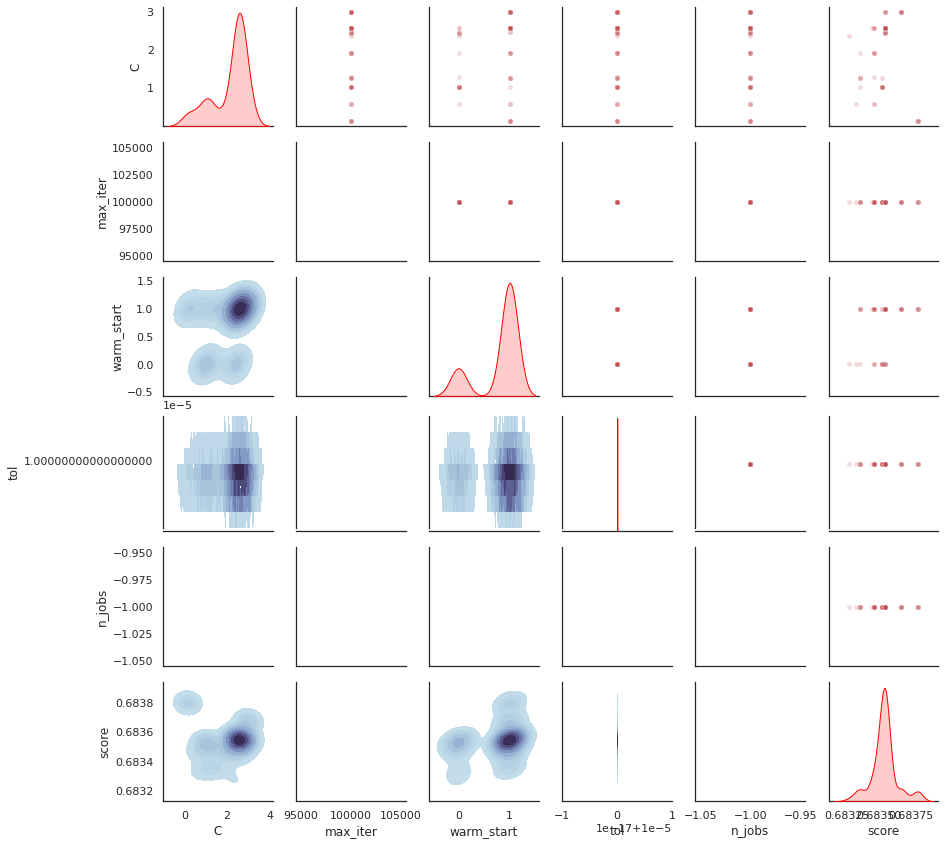

In [ ]:
tfidf_unibi.hyperparameter_tune()

In [ ]:
tfidf_unibi.fit()

              precision    recall  f1-score   support

           0       0.75      0.78      0.77      1065
           1       0.58      0.36      0.44       296
           2       0.66      0.71      0.68       921

    accuracy                           0.70      2282
   macro avg       0.66      0.62      0.63      2282
weighted avg       0.69      0.70      0.69      2282

Accuracy is 69.72 %


Plotting learning curve...


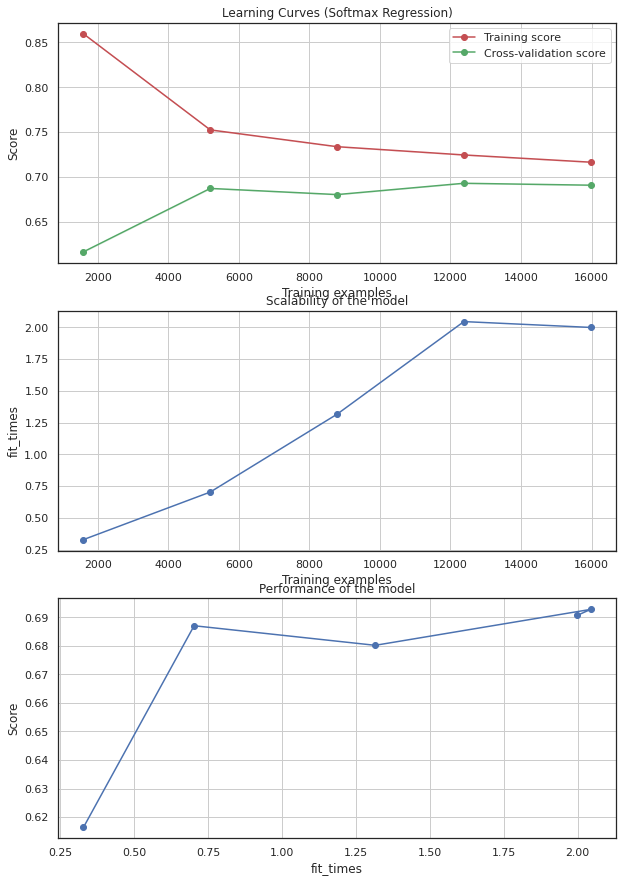

In [ ]:
tfidf_unibi.plot_learning_curve()

### 3.4) Use Count Vectorizer representation with only unigrams

Received input
Instantiating Lemmatizer... Done
Dropping null values... Done
Cleaning the dataset... 

  0%|          | 0/15976 [00:00<?, ?it/s]

  0%|          | 0/2282 [00:00<?, ?it/s]

Done
Displaying wordcloud... 

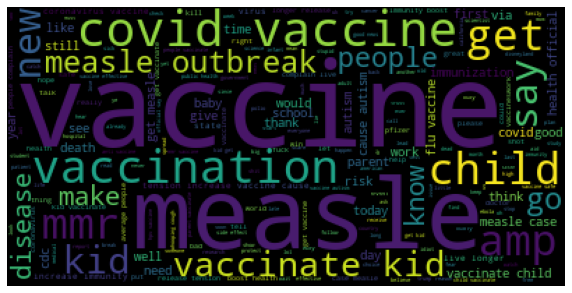


Done
Vectorizing... Done


In [ ]:
bow_uni = Softmax_Regressor(training_set, val_set, 
                                    CountVectorizer(ngram_range=(1, 1), 
                                        stop_words=nltk.corpus.stopwords.words(), 
                                         min_df=0.005, max_df=0.85))

Running GA Search for hyperparameter tuning... 
gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	10    	0.670136	6.19928e-05	0.670228   	0.670087   
1  	18    	0.670189	6.34507e-05	0.670234   	0.670087   
2  	17    	0.670232	3.71566e-06	0.670234   	0.670224   
3  	19    	0.670234	0          	0.670234   	0.670234   
4  	18    	0.670234	0          	0.670234   	0.670234   
Done
Tuned hyperparameters :(best parameters)  {'C': 1.8460811830508776, 'penalty': 'l2', 'solver': 'sag', 'max_iter': 100000, 'warm_start': False, 'tol': 1e-05, 'n_jobs': -1}
Accuracy : 0.4925503943908852


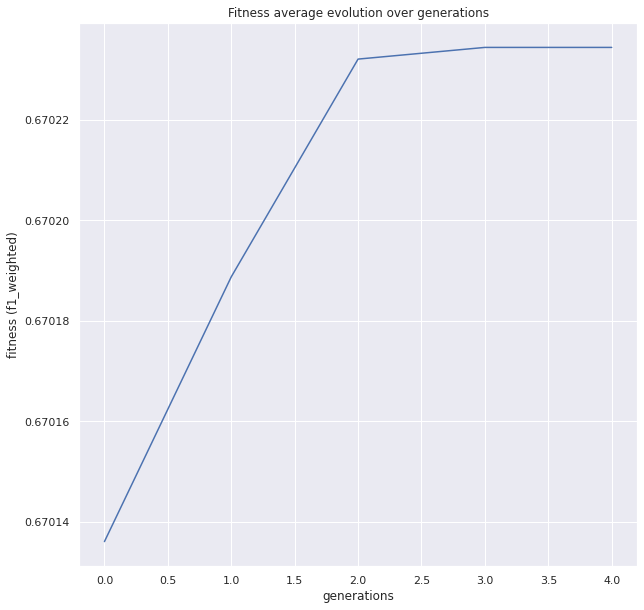

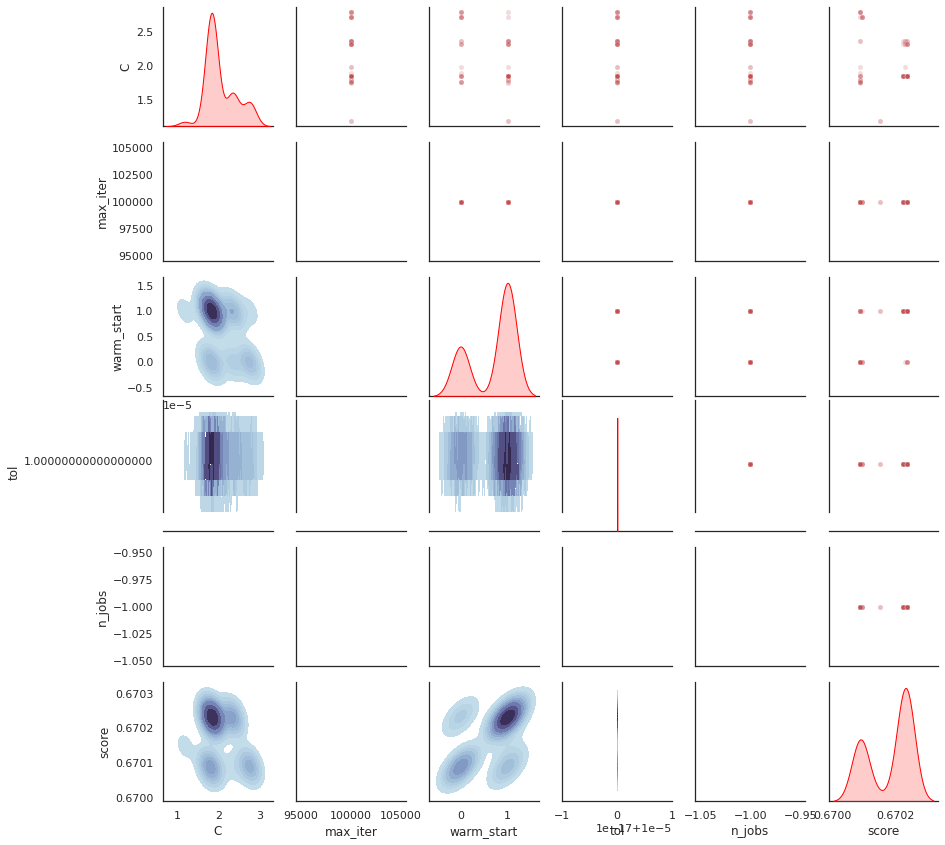

In [ ]:
bow_uni.hyperparameter_tune()

In [ ]:
bow_uni.fit()

              precision    recall  f1-score   support

           0       0.75      0.77      0.76      1065
           1       0.56      0.30      0.39       296
           2       0.65      0.72      0.69       921

    accuracy                           0.69      2282
   macro avg       0.65      0.60      0.61      2282
weighted avg       0.68      0.69      0.68      2282

Accuracy is 69.19 %


Plotting learning curve...


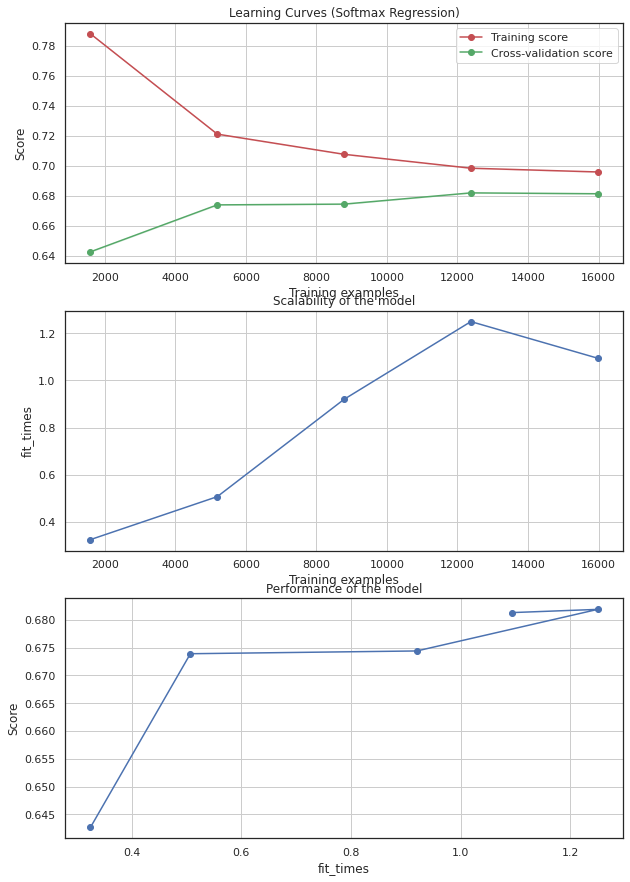

In [ ]:
bow_uni.plot_learning_curve()

### 3.5) Use Count Vectorizer representation with only bigrams

Received input
Instantiating Lemmatizer... Done
Dropping null values... Done
Cleaning the dataset... 

  0%|          | 0/15976 [00:00<?, ?it/s]

  0%|          | 0/2282 [00:00<?, ?it/s]

Done
Displaying wordcloud... 

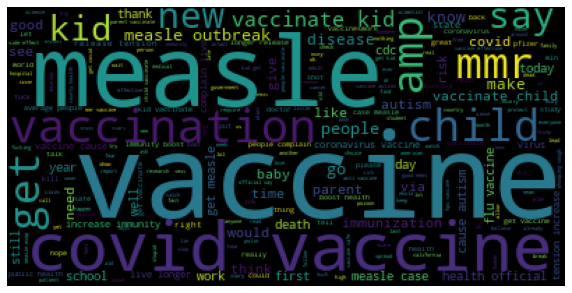


Done
Vectorizing... Done


In [ ]:
bow_bi = Softmax_Regressor(training_set, val_set, 
                                    CountVectorizer(ngram_range=(2, 2), 
                                        stop_words=nltk.corpus.stopwords.words(), 
                                         min_df=0.003, max_df=0.9))

Running GA Search for hyperparameter tuning... 
gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	10    	0.549641	5.14198e-05	0.549767   	0.549599   
1  	19    	0.549736	4.7671e-05 	0.549767   	0.549658   
2  	19    	0.549767	0          	0.549767   	0.549767   
3  	20    	0.549767	0          	0.549767   	0.549767   
4  	15    	0.549767	0          	0.549767   	0.549767   
Done
Tuned hyperparameters :(best parameters)  {'C': 0.12498404292306954, 'penalty': 'l2', 'solver': 'newton-cg', 'max_iter': 100000, 'warm_start': True, 'tol': 1e-05, 'n_jobs': -1}
Accuracy : 0.5017528483786152


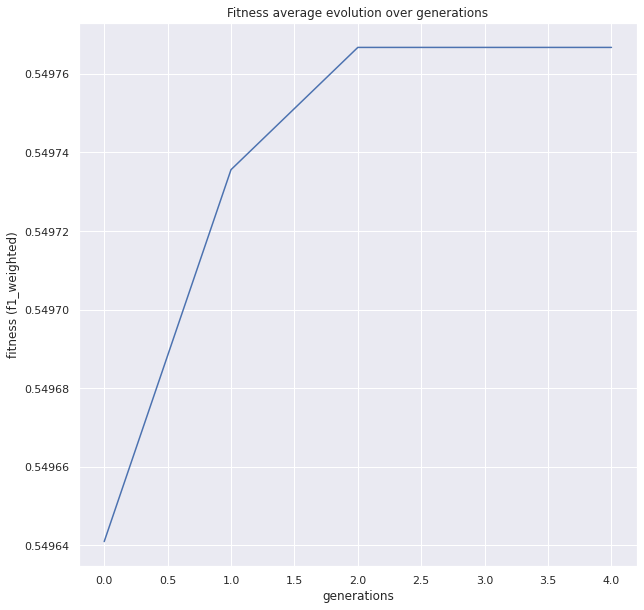

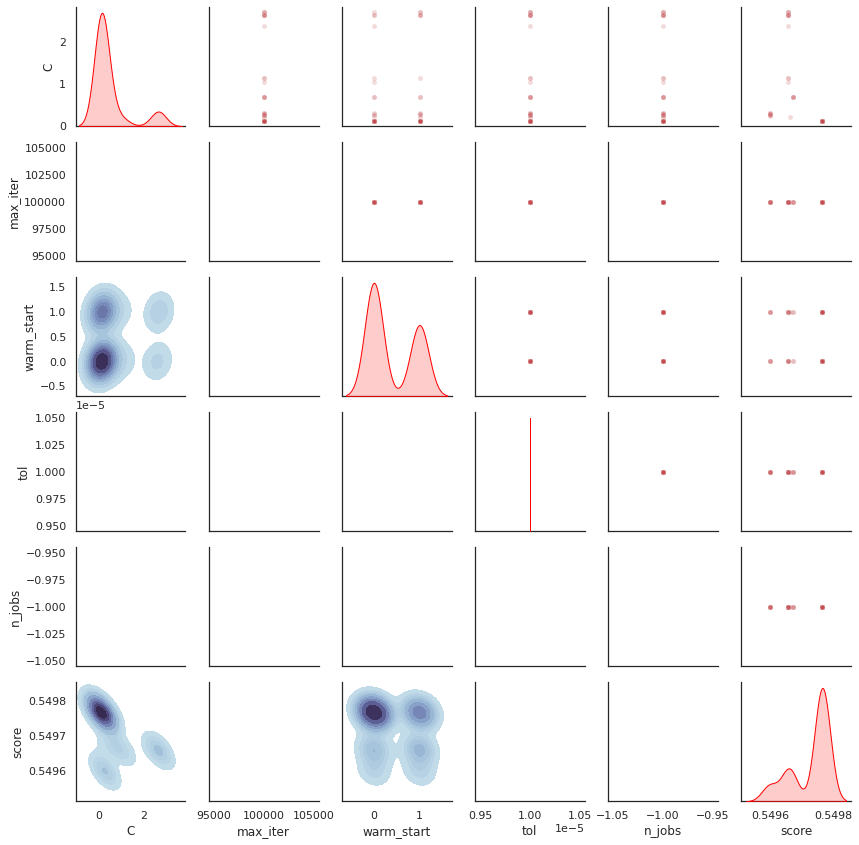

In [ ]:
bow_bi.hyperparameter_tune()

In [ ]:
bow_bi.fit()

              precision    recall  f1-score   support

           0       0.58      0.89      0.70      1065
           1       0.47      0.05      0.09       296
           2       0.67      0.44      0.53       921

    accuracy                           0.60      2282
   macro avg       0.57      0.46      0.44      2282
weighted avg       0.60      0.60      0.55      2282

Accuracy is 60.04 %


Plotting learning curve...


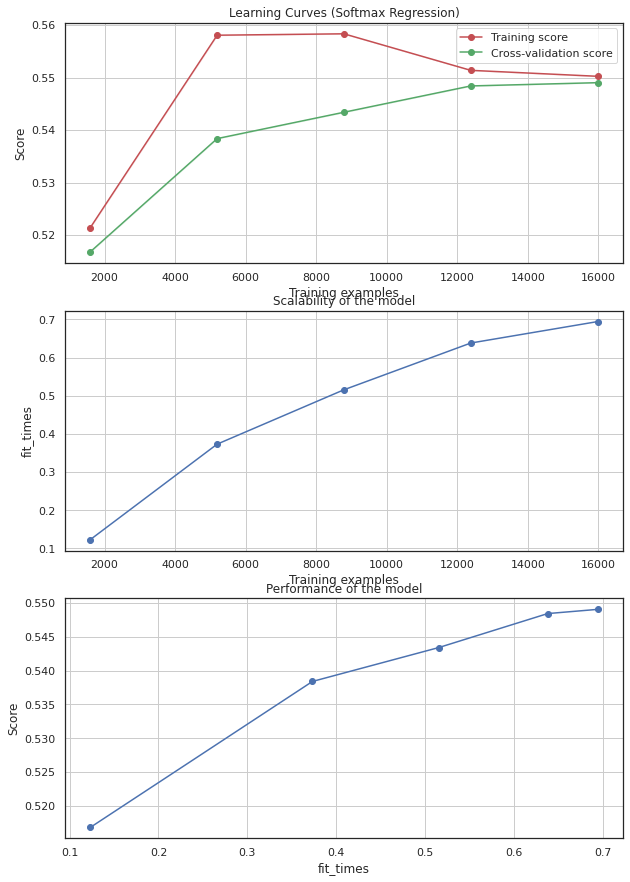

In [ ]:
bow_bi.plot_learning_curve()

### 3.6) Use Count Vectorizer representation with both unigrams and bigrams



Received input
Instantiating Lemmatizer... Done
Dropping null values... Done
Cleaning the dataset... 

  0%|          | 0/15976 [00:00<?, ?it/s]

  0%|          | 0/2282 [00:00<?, ?it/s]

Done
Displaying wordcloud... 

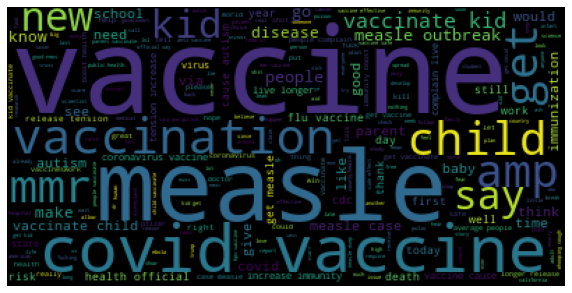


Done
Vectorizing... Done


In [ ]:
bow_unibi = Softmax_Regressor(training_set, val_set, 
                                    CountVectorizer(ngram_range=(1, 2), 
                                        stop_words=nltk.corpus.stopwords.words(),
                                         min_df=0.005, max_df=0.85))

Running GA Search for hyperparameter tuning... 
gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	10    	0.673263	0.000597956	0.673559   	0.671483   
1  	15    	0.673559	1.11022e-16	0.673559   	0.673559   
2  	20    	0.673559	1.11022e-16	0.673559   	0.673559   
3  	17    	0.673559	1.11022e-16	0.673559   	0.673559   
4  	17    	0.673559	1.11022e-16	0.673559   	0.673559   
Done
Tuned hyperparameters :(best parameters)  {'C': 1.6258137375142858, 'penalty': 'l2', 'solver': 'newton-cg', 'max_iter': 100000, 'warm_start': False, 'tol': 1e-05, 'n_jobs': -1}
Accuracy : 0.49868536371603855


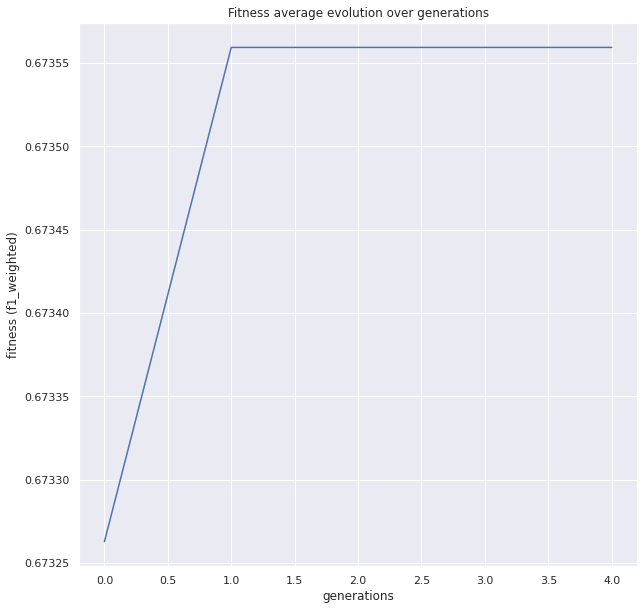

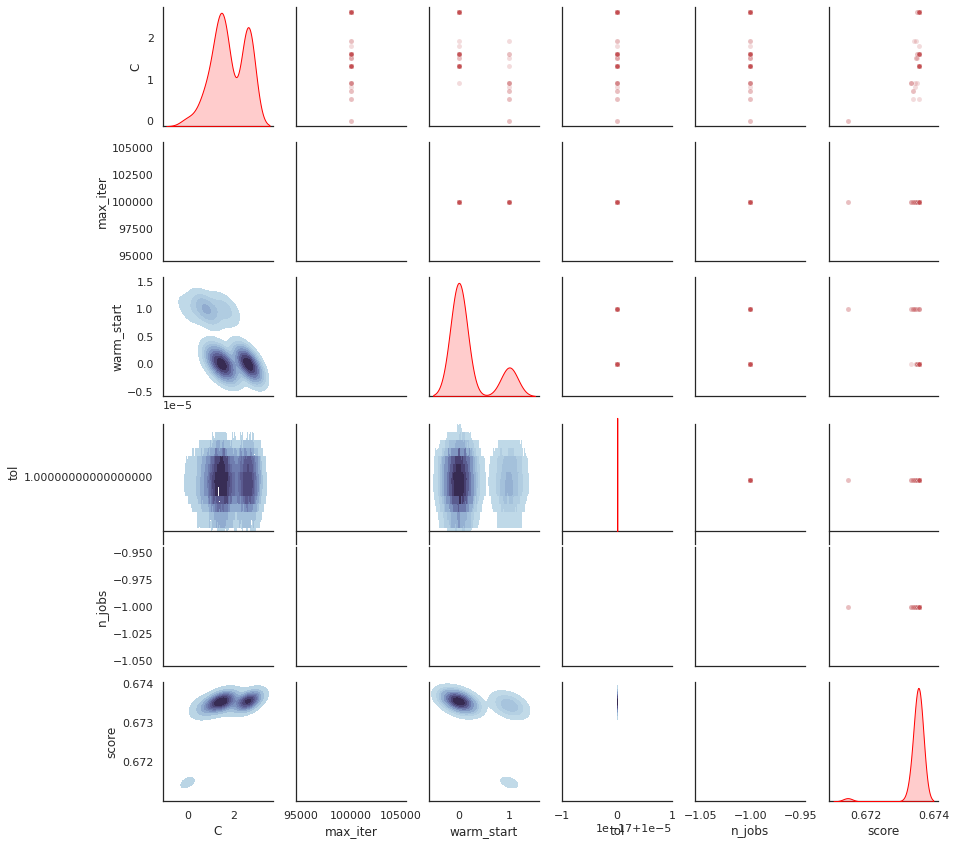

In [ ]:
bow_unibi.hyperparameter_tune()

In [ ]:
bow_unibi.fit()

              precision    recall  f1-score   support

           0       0.74      0.78      0.76      1065
           1       0.56      0.30      0.39       296
           2       0.65      0.72      0.68       921

    accuracy                           0.69      2282
   macro avg       0.65      0.60      0.61      2282
weighted avg       0.68      0.69      0.68      2282

Accuracy is 69.15 %


Plotting learning curve...


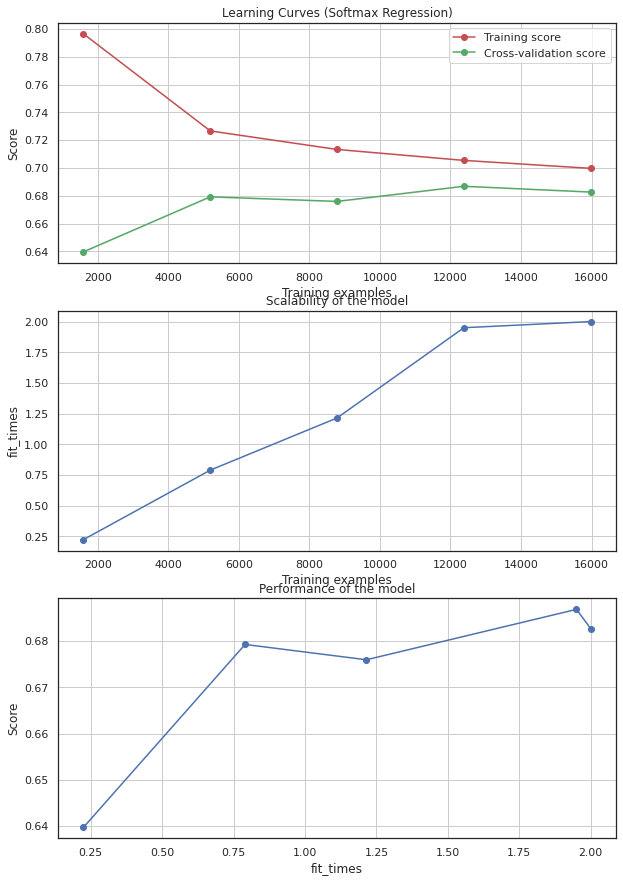

In [ ]:
bow_unibi.plot_learning_curve()

### 3.7) Use Hashing vectorizer representation with only unigrams


Received input
Instantiating Lemmatizer... Done
Dropping null values... Done
Cleaning the dataset... 

  0%|          | 0/15976 [00:00<?, ?it/s]

  0%|          | 0/2282 [00:00<?, ?it/s]

Done
Displaying wordcloud... 

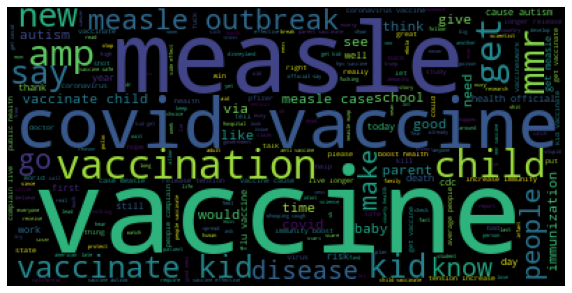


Done
Vectorizing... Done


In [ ]:
h_uni = Softmax_Regressor(training_set, val_set, 
                                    HashingVectorizer(ngram_range=(1, 1), 
                                                      analyzer='word',
                                                      stop_words=nltk.corpus.stopwords.words(), 
                                                      n_features=2**6,
                                                      norm=None))

Running GA Search for hyperparameter tuning... 
gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	10    	0.574338	3.05438e-05	0.574402   	0.574319   
1  	17    	0.57436 	3.55618e-05	0.574402   	0.574319   
2  	17    	0.574391	2.52744e-05	0.574402   	0.574319   
3  	17    	0.574402	1.11022e-16	0.574402   	0.574402   
4  	17    	0.574402	1.11022e-16	0.574402   	0.574402   
Done
Tuned hyperparameters :(best parameters)  {'C': 0.14382801532022857, 'penalty': 'l2', 'solver': 'newton-cg', 'max_iter': 100000, 'warm_start': False, 'tol': 1e-05, 'n_jobs': -1}
Accuracy : 0.5867659947414549


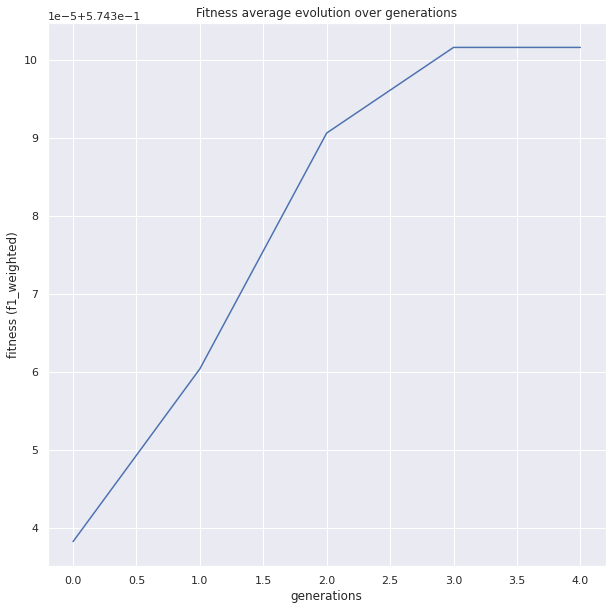

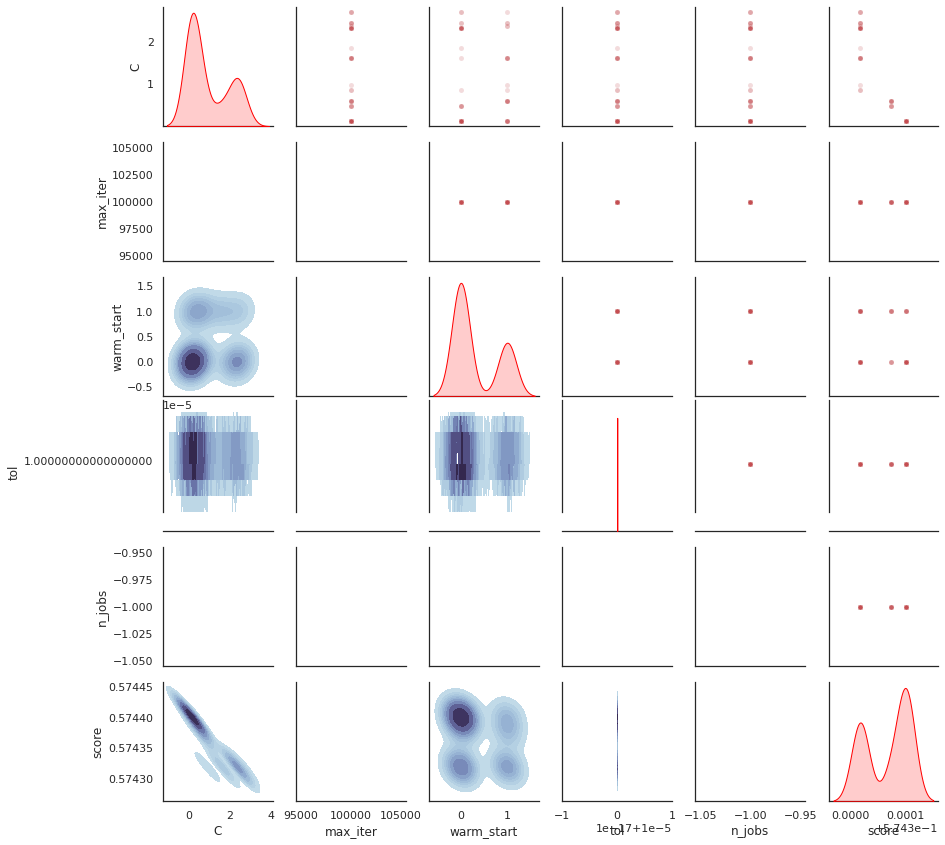

In [ ]:
h_uni.hyperparameter_tune()

In [ ]:
h_uni.fit()

              precision    recall  f1-score   support

           0       0.64      0.75      0.69      1065
           1       0.39      0.08      0.13       296
           2       0.58      0.62      0.60       921

    accuracy                           0.61      2282
   macro avg       0.54      0.48      0.47      2282
weighted avg       0.58      0.61      0.58      2282

Accuracy is 60.82 %


Plotting learning curve...


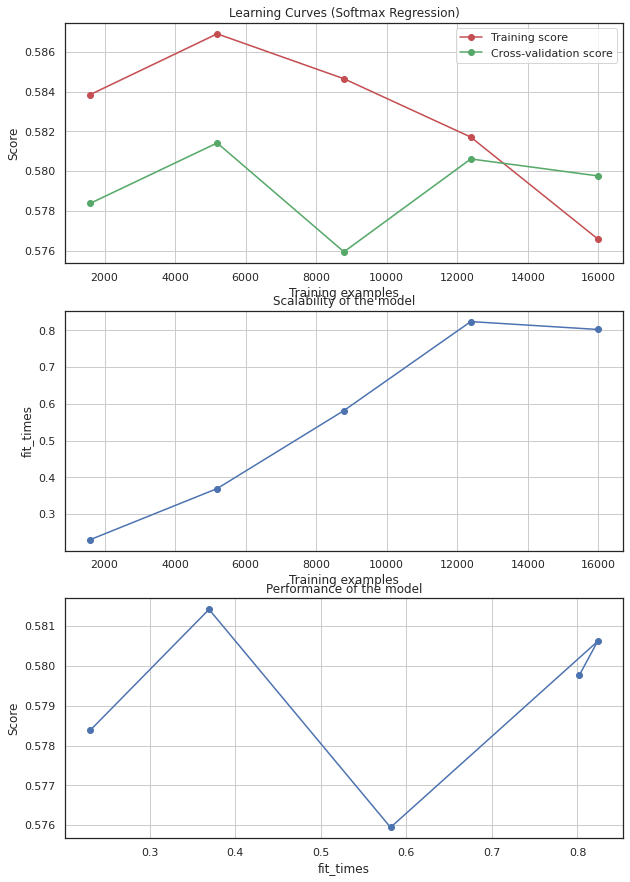

In [ ]:
h_uni.plot_learning_curve()

### 3.8) Use Hashing vectorizer representation with only bigrams


Received input
Instantiating Lemmatizer... Done
Dropping null values... Done
Cleaning the dataset... 

  0%|          | 0/15976 [00:00<?, ?it/s]

  0%|          | 0/2282 [00:00<?, ?it/s]

Done
Displaying wordcloud... 

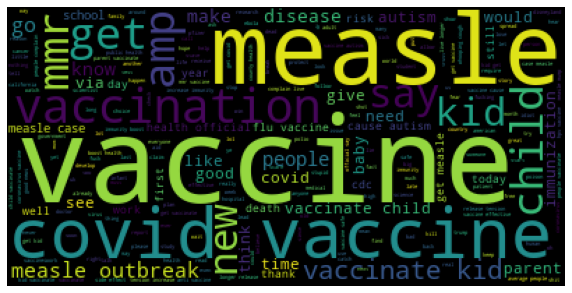


Done
Vectorizing... Done


In [ ]:
h_bi = Softmax_Regressor(training_set, val_set, 
                                    HashingVectorizer(ngram_range=(2, 2), 
                                                      analyzer='word',
                                                      stop_words=nltk.corpus.stopwords.words(), 
                                                      n_features=2**6,
                                                      norm=None))

Running GA Search for hyperparameter tuning... 
gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	10    	0.458955	1.53162e-05	0.459001   	0.45895    
1  	18    	0.458955	1.53162e-05	0.459001   	0.45895    
2  	20    	0.458955	1.53162e-05	0.459001   	0.45895    
3  	18    	0.45896 	2.04216e-05	0.459001   	0.45895    
4  	19    	0.458966	2.33958e-05	0.459001   	0.45895    
Done
Tuned hyperparameters :(best parameters)  {'C': 0.17098151495449143, 'penalty': 'l2', 'solver': 'lbfgs', 'max_iter': 100000, 'warm_start': False, 'tol': 1e-05, 'n_jobs': -1}
Accuracy : 0.4890446976336547


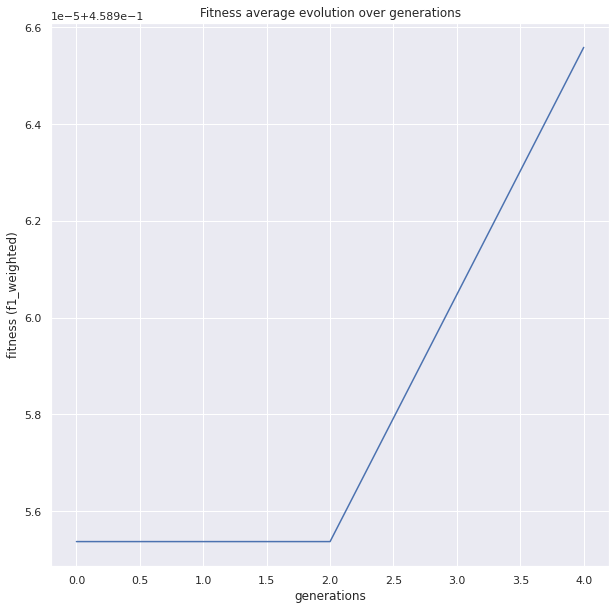

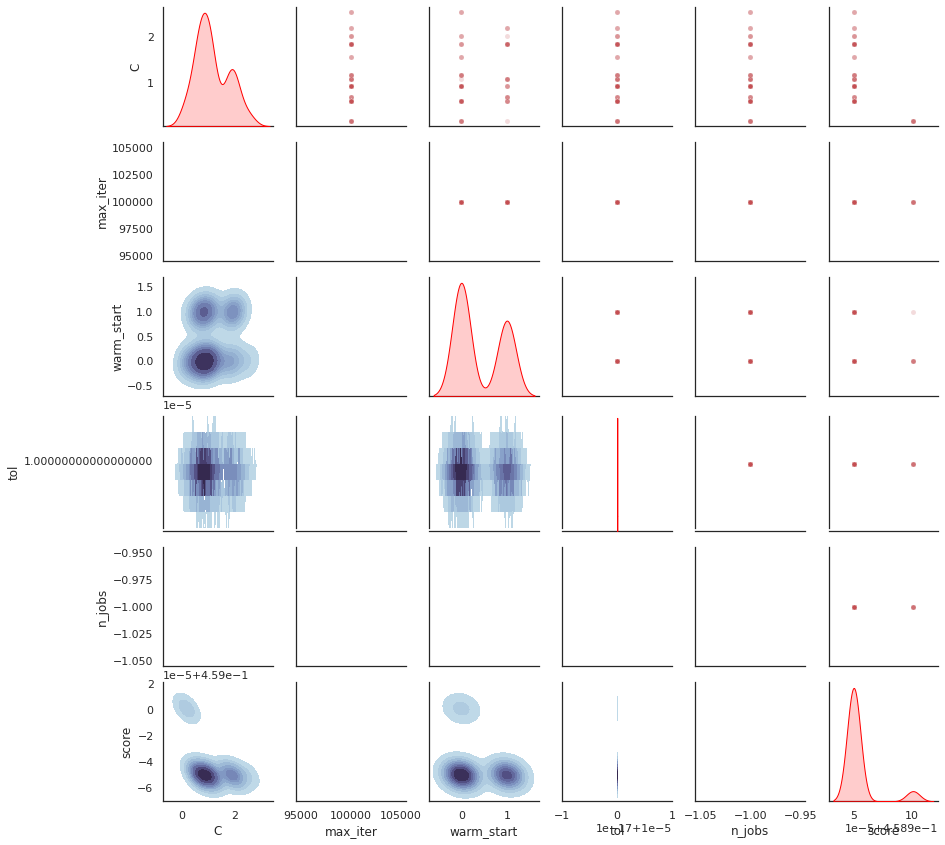

In [ ]:
h_bi.hyperparameter_tune()

In [ ]:
h_bi.fit()

              precision    recall  f1-score   support

           0       0.52      0.75      0.61      1065
           1       0.00      0.00      0.00       296
           2       0.50      0.40      0.45       921

    accuracy                           0.51      2282
   macro avg       0.34      0.38      0.35      2282
weighted avg       0.44      0.51      0.47      2282

Accuracy is 51.14 %


Plotting learning curve...


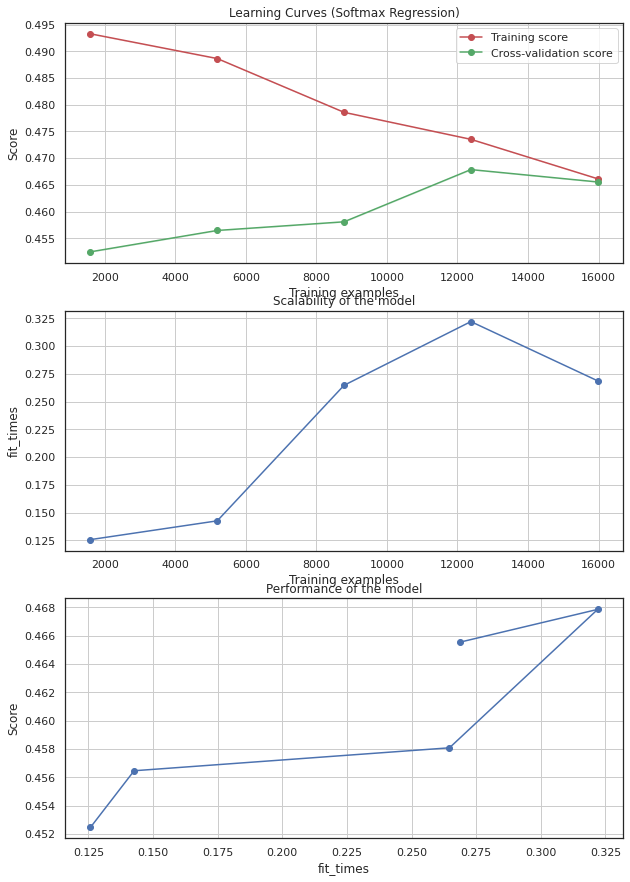

In [ ]:
h_bi.plot_learning_curve()

### 3.9) Use Hashing vectorizer representation with both unigrams and bigrams


Received input
Instantiating Lemmatizer... Done
Dropping null values... Done
Cleaning the dataset... 

  0%|          | 0/15976 [00:00<?, ?it/s]

  0%|          | 0/2282 [00:00<?, ?it/s]

Done
Displaying wordcloud... 

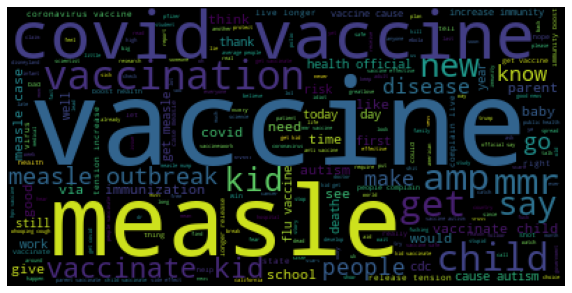


Done
Vectorizing... Done


In [ ]:
h_unibi = Softmax_Regressor(training_set, val_set, 
                                    HashingVectorizer(ngram_range=(1, 2), 
                                                      analyzer='word',
                                                      stop_words=nltk.corpus.stopwords.words(), 
                                                      n_features=2**6,
                                                      norm=None))

Running GA Search for hyperparameter tuning... 
gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	10    	0.543151	1.11022e-16	0.543151   	0.543151   
1  	18    	0.543151	1.11022e-16	0.543151   	0.543151   
2  	19    	0.543151	1.11022e-16	0.543151   	0.543151   
3  	20    	0.543164	2.508e-05  	0.543214   	0.543151   
4  	19    	0.543176	3.07165e-05	0.543214   	0.543151   
Done
Tuned hyperparameters :(best parameters)  {'C': 2.739131286986934, 'penalty': 'l2', 'solver': 'lbfgs', 'max_iter': 100000, 'warm_start': True, 'tol': 1e-05, 'n_jobs': -1}
Accuracy : 0.5635407537248028


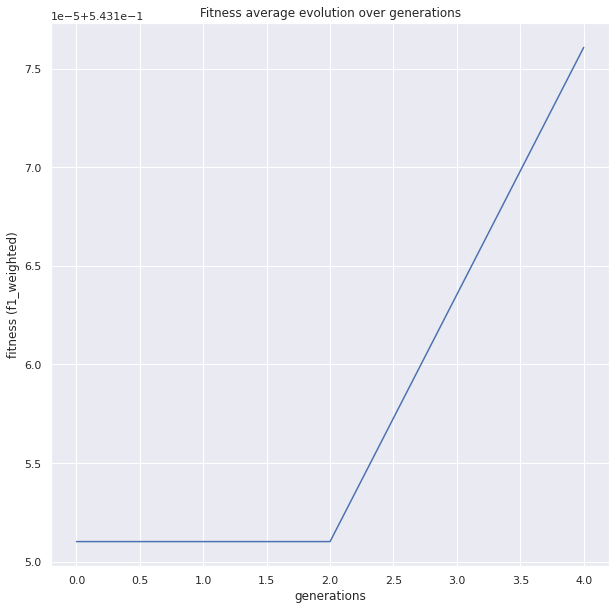

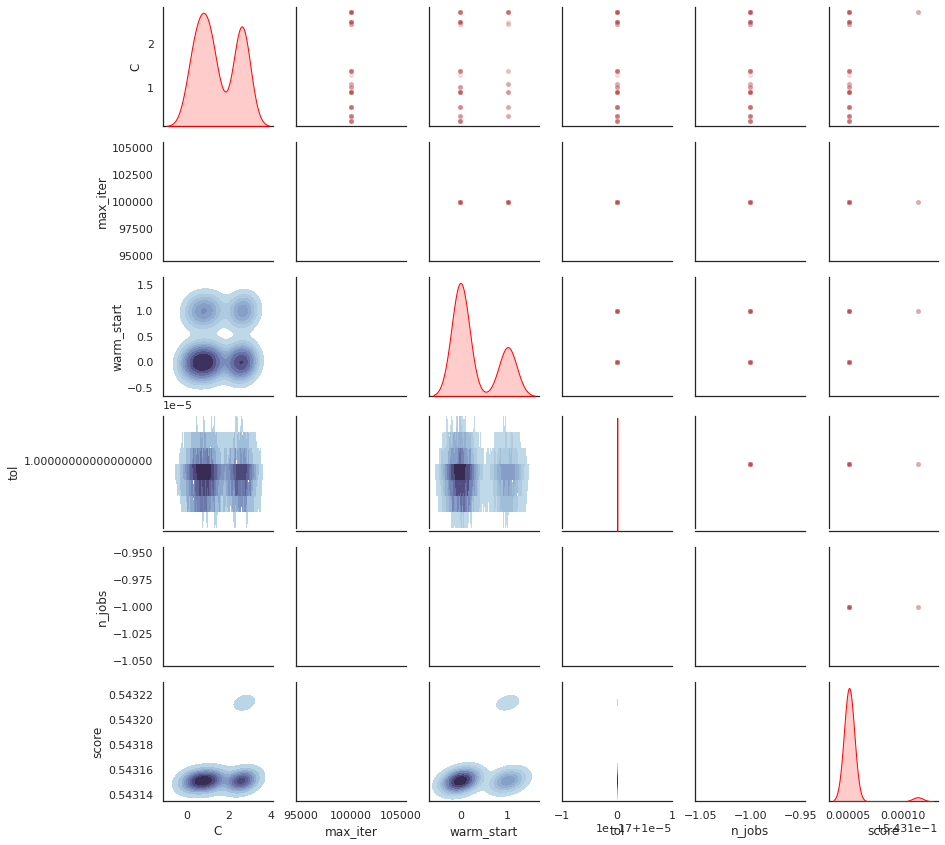

In [ ]:
h_unibi.hyperparameter_tune()

In [ ]:
h_unibi.fit()

              precision    recall  f1-score   support

           0       0.60      0.72      0.65      1065
           1       0.50      0.06      0.10       296
           2       0.55      0.57      0.56       921

    accuracy                           0.57      2282
   macro avg       0.55      0.45      0.44      2282
weighted avg       0.56      0.57      0.54      2282

Accuracy is 57.32 %


Plotting learning curve...


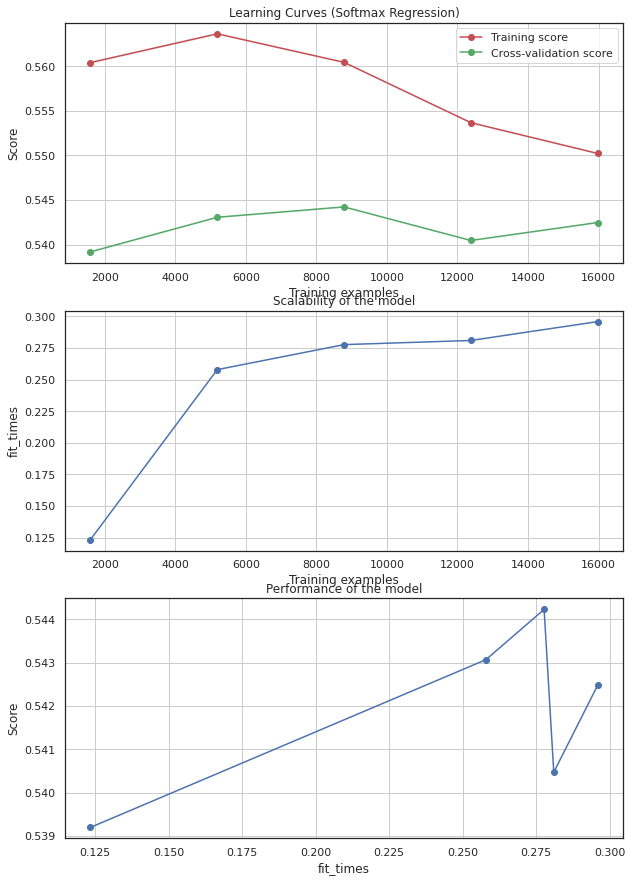

In [ ]:
h_unibi.plot_learning_curve()

#4) Results

After  preprocessing  and  experimenting  with  a  wide  variety of representations and hyperparameter grids, the best performing model resulted to be a TF-IDF represented model, made up with both unigams and bigrams.  It scored a weighted f1-score of **69%**.

# 5) Test your own set!

In [ ]:
training_set_path = r'YOUR TRAINING SET LINK GOES HERE'
test_set_path     = r'YOUR TEST SET LINK GOES HERE'

training_set = pd.read_csv(training_set_path, index_col=0)
test_set = pd.read_csv(test_set_path, index_col=0)

In [ ]:
exam = Softmax_Regressor(training_set, test_set)

In [ ]:
exam.hyperparameter_tune()      # OPTIONAL; Bypass this if you want

In [ ]:
exam.fit()

In [ ]:
exam.plot_learning_curve()

# 6) Sources

* [Fake News Detection System](https://github.com/spChalk/Fake-News-Detection/blob/main/fake-news-detection-sys.ipynb) written **in collaboration with Charalampos Maraziaris - 1115201800105**

* *https://scikit-learn.org/stable/*

* *https://stackoverflow.com*

* *https://medium.com/*

* *https://towardsdatascience.com/*